In [4]:
import pandas as pd

# 读取数据
df = pd.read_excel("default of credit card clients.xls", header=1)  # header=1 是因为第2行才是字段名

# 重命名最后一列（因为默认读取时列名太长）
df.rename(columns={"default payment next month": "default"}, inplace=True)

# 初步查看数据
print("数据维度：", df.shape)
print("\n字段信息：")
print(df.dtypes)

print("\n前5行：")
print(df.head())

# 检查缺失值
print("\n缺失值统计：")
print(df.isnull().sum())


数据维度： (30000, 25)

字段信息：
ID           int64
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
default      int64
dtype: object

前5行：
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ..


字段数据类型：
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
default      int64
dtype: object

每列唯一值数量：
LIMIT_BAL       81
SEX              2
EDUCATION        7
MARRIAGE         4
AGE             56
PAY_0           11
PAY_2           11
PAY_3           11
PAY_4           11
PAY_5           10
PAY_6           10
BILL_AMT1    22723
BILL_AMT2    22346
BILL_AMT3    22026
BILL_AMT4    21548
BILL_AMT5    21010
BILL_AMT6    20604
PAY_AMT1      7943
PAY_AMT2      7899
PAY_AMT3      7518
PAY_AMT4      6937
PAY_AMT5      6897
PAY_AMT6      6939
default          2
dtype: int64

除还款/账单列以外的负数值统计：


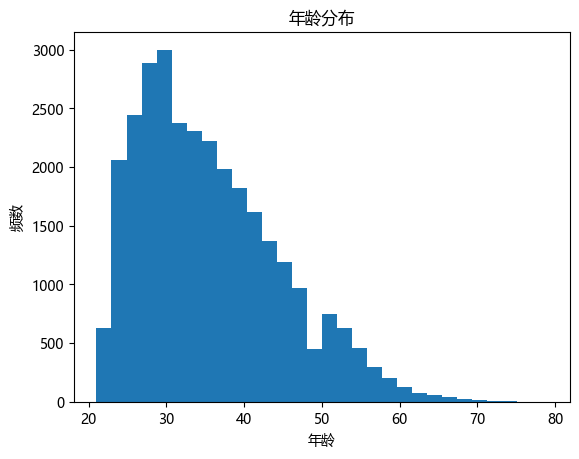

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_excel("default of credit card clients.xls", header=1)
df.rename(columns={"default payment next month": "default"}, inplace=True)

# 删除 ID 列
df.drop(columns=['ID'], inplace=True)

# 检查数据类型
print("\n字段数据类型：")
print(df.dtypes)

# 查看每列的唯一值数量（判断类别/数值型特征）
print("\n每列唯一值数量：")
print(df.nunique())

# 查看是否有负数的列（除还款状态、账单、还款金额外，负值可能不合理）
exclude_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# 检查其他列中是否有负数
print("\n除还款/账单列以外的负数值统计：")
for col in df.columns:
    if col not in exclude_cols and (df[col] < 0).any():
        print(f"{col} 存在负值，最小值为 {df[col].min()}")

# 画出 AGE 的直方图作为例子
plt.hist(df['AGE'], bins=30)
plt.title("年龄分布")
plt.xlabel("年龄")
plt.ylabel("频数")
plt.show()


In [6]:
# EDUCATION 清洗：把0,5,6合并为4（其他）
df['EDUCATION'] = df['EDUCATION'].replace({0:4, 5:4, 6:4})

# MARRIAGE 清洗：把0当作“未知”
df['MARRIAGE'] = df['MARRIAGE'].replace({0:3})  # 用3代替“其他”类别，或者自己定义

# 检查清洗后类别数量
print("清洗后 EDUCATION 唯一值:", df['EDUCATION'].unique())
print("清洗后 MARRIAGE 唯一值:", df['MARRIAGE'].unique())


清洗后 EDUCATION 唯一值: [2 1 3 4]
清洗后 MARRIAGE 唯一值: [1 2 3]


In [7]:
import pandas as pd
import numpy as np

def calc_woe_iv(df, feature, target, bins=5):
    """
    计算变量的WOE和IV
    参数：
        df: pandas DataFrame，包含feature和target列
        feature: 待计算的变量名（字符串）
        target: 目标变量名（字符串），二分类（0/1）
        bins: 分箱数量（默认5）
    返回：
        woe_df: 各分箱的统计结果，包括WOE和坏好客户占比
        woe_dict: 分箱对应的WOE映射字典，方便映射变量
        iv: 该变量的IV值
    """
    # 分箱，包含最大值
    df['bin'] = pd.cut(df[feature], bins=bins, duplicates='drop')
    
    grouped = df.groupby('bin')[target]
    
    # 每箱的好坏客户数（0为好，1为坏）
    count_good = grouped.apply(lambda x: (x==0).sum())
    count_bad = grouped.apply(lambda x: (x==1).sum())
    
    # 总体好坏客户数
    total_good = (df[target] == 0).sum()
    total_bad = (df[target] == 1).sum()
    
    # 好坏客户占比
    distr_good = count_good / total_good
    distr_bad = count_bad / total_bad
    
    # 防止0导致计算异常，加极小值平滑
    distr_good = distr_good.replace(0, 0.0001)
    distr_bad = distr_bad.replace(0, 0.0001)
    
    # 计算WOE
    woe = np.log(distr_good / distr_bad)
    
    # 计算IV
    iv = ((distr_good - distr_bad) * woe).sum()
    
    woe_df = pd.DataFrame({
        'count_good': count_good,
        'count_bad': count_bad,
        'distr_good': distr_good,
        'distr_bad': distr_bad,
        'woe': woe
    })
    
    # 构造映射字典，key是区间，value是WOE
    woe_dict = woe.to_dict()
    
    # 删除临时列
    df.drop(columns=['bin'], inplace=True)
    
    return woe_df, woe_dict, iv

# 测试示例
woe_df, woe_dict, iv = calc_woe_iv(df, 'AGE', 'default', bins=5)
print(woe_df)
print(f'IV of AGE: {iv:.4f}')


                count_good  count_bad  distr_good  distr_bad       woe
bin                                                                   
(20.942, 32.6]       10463       2925    0.447826   0.440778  0.015864
(32.6, 44.2]          8909       2417    0.381313   0.364225  0.045848
(44.2, 55.8]          3372       1070    0.144325   0.161242 -0.110840
(55.8, 67.4]           586        213    0.025081   0.032098 -0.246659
(67.4, 79.0]            34         11    0.001455   0.001658 -0.130222
IV of AGE: 0.0045


In [8]:
import pandas as pd
import numpy as np

def calc_woe_iv(df, feature, target, bins=5):
    """
    计算单个特征的WOE和IV
    对连续变量使用分箱，离散变量直接分组
    """
    df2 = df[[feature, target]].copy()
    # 判断是否连续型，简单判定：如果唯一值 > bins，认为连续变量
    if df[feature].nunique() > bins:
        df2['bin'] = pd.qcut(df2[feature], q=bins, duplicates='drop')
    else:
        df2['bin'] = df2[feature]
    
    grouped = df2.groupby('bin')
    total_good = (df2[target] == 0).sum()
    total_bad = (df2[target] == 1).sum()

    stats = pd.DataFrame()
    stats['count_good'] = grouped.apply(lambda x: (x[target] == 0).sum())
    stats['count_bad'] = grouped.apply(lambda x: (x[target] == 1).sum())

    stats['distr_good'] = stats['count_good'] / total_good
    stats['distr_bad'] = stats['count_bad'] / total_bad

    # 计算WOE，避免除0或log0，用1e-6平滑
    stats['woe'] = np.log((stats['distr_good'] + 1e-6) / (stats['distr_bad'] + 1e-6))
    stats['iv'] = (stats['distr_good'] - stats['distr_bad']) * stats['woe']
    
    iv = stats['iv'].sum()
    return iv, stats

# 批量计算IV
def calc_iv_for_all(df, target, bins=5):
    iv_dict = {}
    features = df.columns.drop(target)
    for feat in features:
        iv, _ = calc_woe_iv(df, feat, target, bins)
        iv_dict[feat] = iv
    iv_df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=['IV'])
    iv_df = iv_df.sort_values(by='IV', ascending=False)
    return iv_df

# 调用示例：
iv_values = calc_iv_for_all(df, 'default', bins=5)
print(iv_values)


                 IV
PAY_0      0.869374
PAY_2      0.541744
PAY_3      0.408999
PAY_4      0.355173
PAY_5      0.329332
PAY_6      0.281746
LIMIT_BAL  0.155311
PAY_AMT1   0.154802
PAY_AMT2   0.139493
PAY_AMT3   0.116760
PAY_AMT4   0.082210
PAY_AMT6   0.080546
PAY_AMT5   0.068868
EDUCATION  0.037297
BILL_AMT6  0.013403
AGE        0.012575
BILL_AMT5  0.012528
BILL_AMT2  0.010309
BILL_AMT4  0.010248
BILL_AMT1  0.010238
BILL_AMT3  0.009510
SEX        0.009180
MARRIAGE   0.005433


In [9]:
import pandas as pd
import numpy as np

def calc_woe_iv(df, feature, target, bins=5, show_woe=False):
    # 分箱（连续变量）
    if pd.api.types.is_numeric_dtype(df[feature]):
        df['bin'] = pd.qcut(df[feature], bins, duplicates='drop')
    else:
        # 类别变量不用分箱，直接分组
        df['bin'] = df[feature]
    
    grouped = df.groupby('bin')
    
    # 计算每个箱子里的好坏客户数
    stats = pd.DataFrame()
    stats['count_good'] = grouped[target].apply(lambda x: (x == 0).sum())
    stats['count_bad'] = grouped[target].apply(lambda x: (x == 1).sum())
    stats['distr_good'] = stats['count_good'] / stats['count_good'].sum()
    stats['distr_bad'] = stats['count_bad'] / stats['count_bad'].sum()
    
    # 避免0导致的无限大，做平滑处理
    stats['distr_good'] = stats['distr_good'].replace(0, 0.0001)
    stats['distr_bad'] = stats['distr_bad'].replace(0, 0.0001)
    
    # 计算WOE
    stats['woe'] = np.log(stats['distr_good'] / stats['distr_bad'])
    
    # 计算IV
    stats['iv'] = (stats['distr_good'] - stats['distr_bad']) * stats['woe']
    iv = stats['iv'].sum()
    
    if show_woe:
        print(stats[['count_good', 'count_bad', 'woe', 'iv']])
    
    # 映射WOE值
    woe_dict = stats['woe'].to_dict()
    df[feature + '_woe'] = df['bin'].map(woe_dict)
    df.drop(columns=['bin'], inplace=True)
    
    return df, iv


In [10]:
features_to_woe = ['PAY_0', 'PAY_2', 'PAY_3', 'LIMIT_BAL', 'PAY_AMT1']

for feat in features_to_woe:
    df, iv = calc_woe_iv(df, feat, 'default', bins=5, show_woe=True)
    print(f"{feat} IV: {iv:.4f}")


                count_good  count_bad       woe        iv
bin                                                      
(-2.001, -1.0]        7126       1319  0.428189  0.045489
(-1.0, 0.0]          12849       1888  0.659061  0.174941
(0.0, 1.0]            2436       1252 -0.593072  0.050058
(1.0, 8.0]             953       2177 -2.084775  0.598893
PAY_0 IV: 0.8694
                count_good  count_bad       woe        iv
bin                                                      
(-2.001, -1.0]        8175       1657  0.337385  0.033806
(-1.0, 0.0]          13227       2503  0.406083  0.076726
(0.0, 8.0]            1962       2476 -1.491367  0.431215
PAY_2 IV: 0.5417
                count_good  count_bad       woe        iv
bin                                                      
(-2.001, -1.0]        8340       1683  0.341798  0.035322
(-1.0, 0.0]          13013       2751  0.295297  0.042054
(0.0, 8.0]            2011       2202 -1.349421  0.331625
PAY_3 IV: 0.4090
                     

AUC: 0.7539
F1 Score: 0.4523
Confusion Matrix:
[[6680  360]
 [1282  678]]


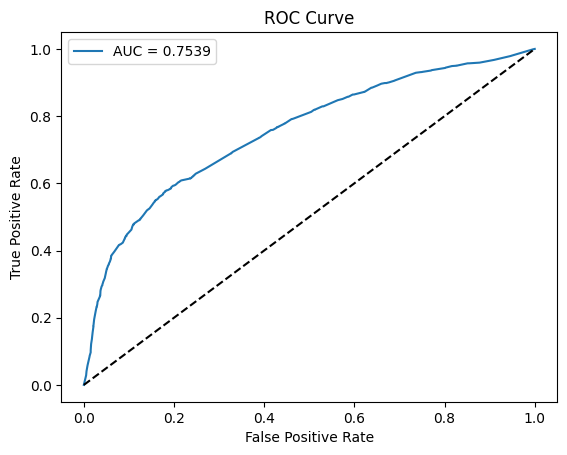

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# 假设df中已经有以下WOE编码列
features_woe = ['PAY_0_woe', 'PAY_2_woe', 'PAY_3_woe', 'LIMIT_BAL_woe', 'PAY_AMT1_woe']

X = df[features_woe]
y = df['default']

# 划分训练和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练逻辑回归
model = LogisticRegression()
model.fit(X_train, y_train)

# 预测
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# 评估指标
auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# 绘制ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [12]:
import numpy as np

# 假设这是逻辑回归模型参数
intercept = model.intercept_[0]  # 截距
coefs = model.coef_[0]            # 各特征系数

# 设定参数
PDO = 20             # 分数翻倍风险点数
base_score = 600     # 基准分数
base_odds = 50       # 基准好坏比，50:1
factor = PDO / np.log(2)
offset = base_score - factor * np.log(base_odds)

print(f"Factor: {factor:.4f}, Offset: {offset:.4f}")

# 计算每个特征的评分贡献
scores = -coefs * factor  # 负号是因为logit里系数是违约风险增加，分数是风险降低
intercept_score = offset - intercept * factor

print("Intercept score:", intercept_score)
print("Feature scores:", scores)


Factor: 28.8539, Offset: 487.1229
Intercept score: 523.1166220889172
Feature scores: [22.93203347 -0.44364881 13.94244246 15.16566989 14.26499569]


In [15]:
import numpy as np

def calculate_score(X, intercept_score, feature_scores):
    """
    X: numpy数组或DataFrame，形状为 (样本数, 特征数)
    intercept_score: 截距对应分数（浮点数）
    feature_scores: numpy数组，特征对应分数权重，形状 (特征数,)
    返回：样本的信用评分数组
    """
    scores = intercept_score + np.dot(X, feature_scores)
    return scores


In [17]:
import numpy as np

intercept_score = 523.1166220889172
feature_scores = np.array([22.93203347, -0.44364881, 13.94244246, 15.16566989, 14.26499569])


In [18]:
train_scores = calculate_score(X_train.values, intercept_score, feature_scores)
test_scores = calculate_score(X_test.values, intercept_score, feature_scores)


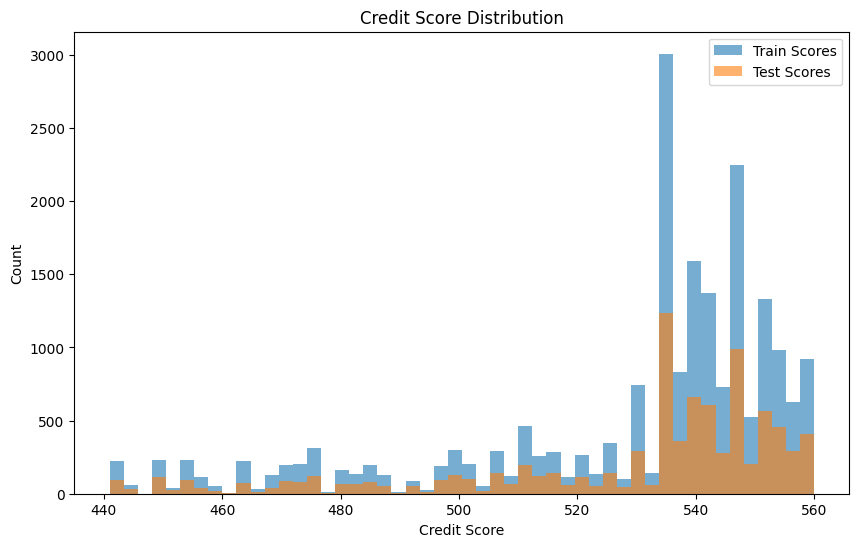

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(train_scores, bins=50, alpha=0.6, label='Train Scores')
plt.hist(test_scores, bins=50, alpha=0.6, label='Test Scores')
plt.xlabel("Credit Score")
plt.ylabel("Count")
plt.title("Credit Score Distribution")
plt.legend()
plt.show()


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

threshold = np.median(test_scores)

y_pred = (test_scores < threshold).astype(int)  # 低分视为高风险违约
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.58      0.70      7040
           1       0.33      0.76      0.46      1960

    accuracy                           0.62      9000
   macro avg       0.62      0.67      0.58      9000
weighted avg       0.77      0.62      0.65      9000



最佳F1阈值：0.2504, F1得分：0.5187
最佳ROC阈值：0.1646, AUC：0.7539


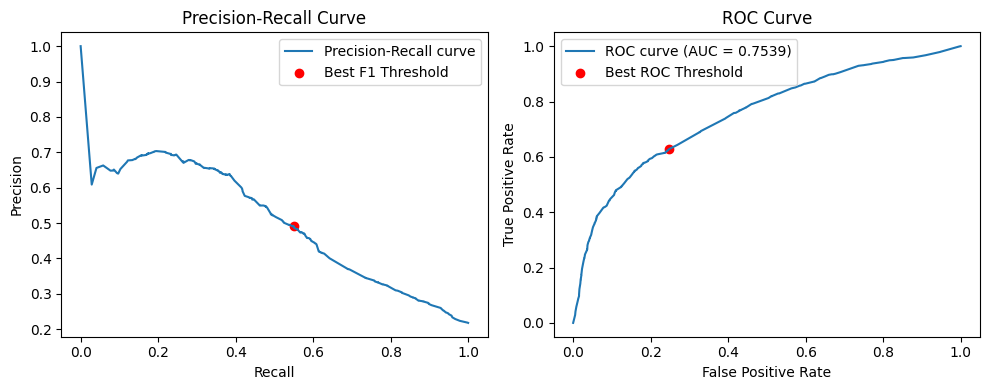

In [21]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 预测正类概率
y_probs = model.predict_proba(X_test)[:,1]

# 计算PR曲线
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)

# 计算F1分数对应的最佳阈值
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
best_index = np.argmax(f1_scores)
best_threshold_pr = thresholds_pr[best_index]
print(f"最佳F1阈值：{best_threshold_pr:.4f}, F1得分：{f1_scores[best_index]:.4f}")

# 绘制PR曲线
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.scatter(recall[best_index], precision[best_index], color='red', label='Best F1 Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# 计算ROC曲线和AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# 找到距离点(0,1)最近的阈值（最佳平衡点）
dist = np.sqrt(fpr**2 + (1 - tpr)**2)
best_index_roc = np.argmin(dist)
best_threshold_roc = thresholds_roc[best_index_roc]
print(f"最佳ROC阈值：{best_threshold_roc:.4f}, AUC：{roc_auc:.4f}")

# 绘制ROC曲线
plt.subplot(1,2,2)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.scatter(fpr[best_index_roc], tpr[best_index_roc], color='red', label='Best ROC Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

# 以最佳阈值为基准，对预测概率分类
y_pred_label = (y_probs >= best_threshold_pr).astype(int)

# 定义风险等级映射函数
def risk_level(score):
    if score >= 700:
        return '低风险'
    elif score >= 600:
        return '中风险'
    else:
        return '高风险'

# 计算评分（示例公式，根据实际情况调整）
score = 850 - (y_probs * 400)

# 转成 Series
score = pd.Series(score)

# 计算风险等级
risk_levels = score.apply(risk_level)

# 合并结果展示
result_df = pd.DataFrame({
    'score': score,
    'risk_level': risk_levels,
    'predicted_default': y_pred_label,
    'actual_default': y_test.reset_index(drop=True)
})

print(result_df.head(10))


        score risk_level  predicted_default  actual_default
0  784.500601        低风险                  0               0
1  806.340876        低风险                  0               0
2  793.790173        低风险                  0               0
3  800.722789        低风险                  0               0
4  785.933126        低风险                  0               1
5  775.261562        低风险                  0               0
6  718.529449        低风险                  1               1
7  718.030417        低风险                  1               0
8  810.716687        低风险                  0               0
9  778.488351        低风险                  0               0


In [26]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 指定一个支持中文的字体路径（Windows通常自带“微软雅黑”）
font_path = "C:/Windows/Fonts/msyh.ttc"
font_prop = FontProperties(fname=font_path)

# 设置全局字体（这样标题、坐标轴文字都会显示中文）
plt.rcParams['font.family'] = font_prop.get_name()

风险等级统计：
  risk_level  count  default_rate
0        中风险    731      0.495212
1        低风险   7612      0.149895
2        高风险    657      0.695586


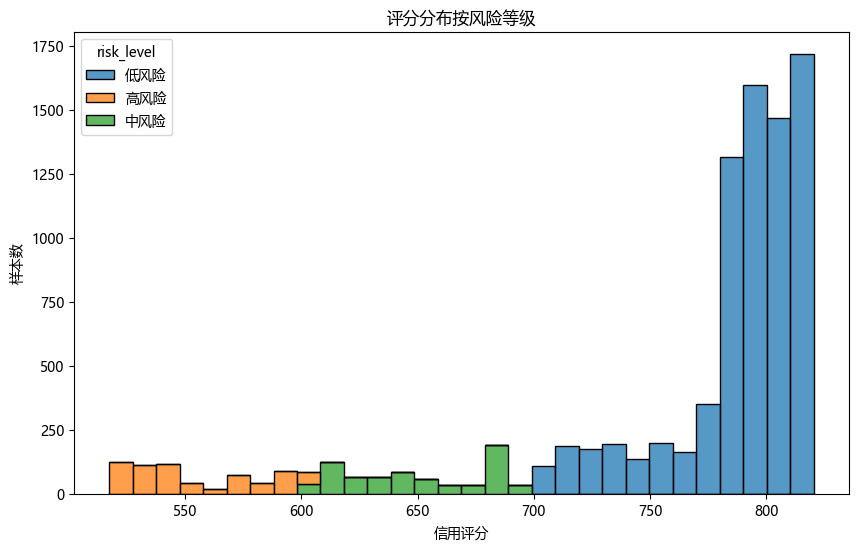

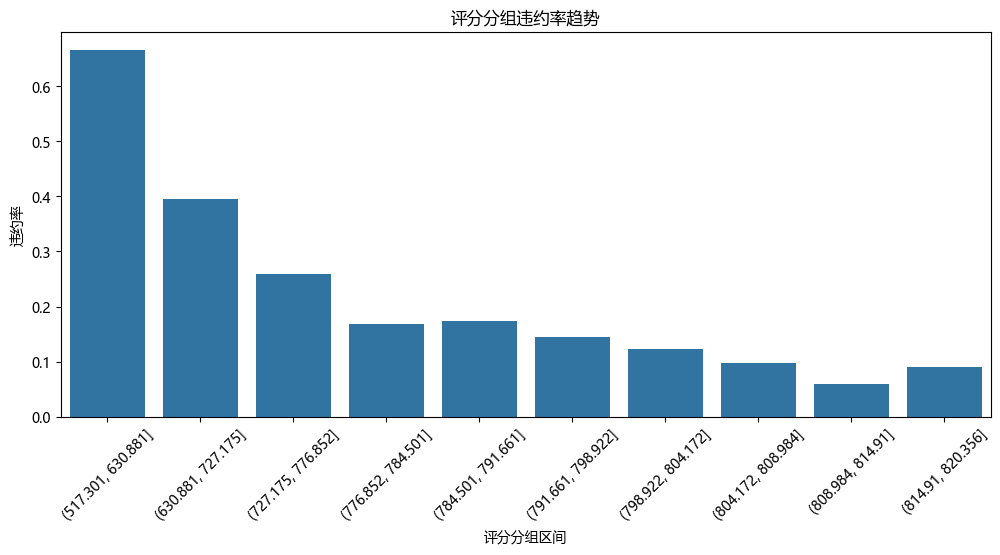

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 统计各风险等级人数及违约率
risk_summary = result_df.groupby('risk_level').agg(
    count=('score', 'count'),
    default_rate=('actual_default', 'mean')
).reset_index()

print("风险等级统计：")
print(risk_summary)

# 画评分分布直方图，按风险等级分色
plt.figure(figsize=(10,6))
sns.histplot(data=result_df, x='score', hue='risk_level', multiple='stack', bins=30)
plt.title('评分分布按风险等级')
plt.xlabel('信用评分')
plt.ylabel('样本数')
plt.show()

# 将评分分成10组，分析每组违约率趋势
result_df['score_group'] = pd.qcut(result_df['score'], 10)
group_default_rate = result_df.groupby('score_group')['actual_default'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.barplot(data=group_default_rate, x='score_group', y='actual_default')
plt.xticks(rotation=45)
plt.title('评分分组违约率趋势')
plt.xlabel('评分分组区间')
plt.ylabel('违约率')
plt.show()


In [36]:
import pandas as pd
import numpy as np

# 示例系数字典（请替换为你的模型 coef）
coef_dict = {
    'PAY_0': 0.8,
    'PAY_2': 0.5,
    'PAY_3': 0.4,
    'LIMIT_BAL': -0.3,
    'PAY_AMT1': -0.2,
}

def generate_scorecard_detail(df, feature, target, coef, bins=5, factor=28.8539):
    """
    生成单个特征的评分卡分箱明细表，包括 WOE 和对应分数
    参数：
        df: DataFrame，包含feature和target列
        feature: 特征名
        target: 目标列名（二分类 0/1）
        coef: 该特征对应的逻辑回归模型系数
        bins: 分箱数量
        factor: 分数因子 (PDO / ln2)
    返回：
        DataFrame 包含分箱区间、好坏客户数、WOE、分数等
    """
    df2 = df[[feature, target]].copy()

    # 判断是否连续型变量，连续用分箱，类别直接分组
    if df[feature].nunique() > bins:
        df2['bin'] = pd.qcut(df2[feature], q=bins, duplicates='drop')
    else:
        df2['bin'] = df2[feature]

    grouped = df2.groupby('bin')

    total_good = (df2[target] == 0).sum()
    total_bad = (df2[target] == 1).sum()

    stats = pd.DataFrame()
    stats['count_good'] = grouped.apply(lambda x: (x[target] == 0).sum())
    stats['count_bad'] = grouped.apply(lambda x: (x[target] == 1).sum())

    stats['distr_good'] = stats['count_good'] / total_good
    stats['distr_bad'] = stats['count_bad'] / total_bad

    # 避免除0或对数0情况，做平滑处理
    stats['distr_good'] = stats['distr_good'].replace(0, 0.0001)
    stats['distr_bad'] = stats['distr_bad'].replace(0, 0.0001)

    # 计算WOE
    stats['woe'] = np.log(stats['distr_good'] / stats['distr_bad'])

    # 计算分数：分数 = - coef * factor * WOE
    stats['score'] = -coef * factor * stats['woe']

    stats = stats.reset_index()

    return stats[['bin', 'count_good', 'count_bad', 'woe', 'score']]

# 批量生成所有特征评分卡分箱明细
def generate_full_scorecard(df, target, coef_dict, bins=5, PDO=20):
    """
    生成完整评分卡明细
    参数：
        df: 数据集
        target: 目标变量名
        coef_dict: {feature: coef} 字典
        bins: 分箱数量
        PDO: 分数翻倍点数（默认20）
    返回：
        dict, key=feature，value=该特征评分卡DataFrame
    """
    factor = PDO / np.log(2)
    scorecard = {}

    for feature, coef in coef_dict.items():
        detail = generate_scorecard_detail(df, feature, target, coef, bins, factor)
        scorecard[feature] = detail

    return scorecard

# 示例调用
# 假设你的 DataFrame 是 df，目标变量名是 'default'
scorecard = generate_full_scorecard(df, 'default', coef_dict, bins=5, PDO=20)

# 打印某个特征的评分卡
for feat, detail in scorecard.items():
    print(f"--- 评分卡分箱明细: {feat} ---")
    print(detail)
    print("\n")


--- 评分卡分箱明细: PAY_0 ---
              bin  count_good  count_bad       woe      score
0  (-2.001, -1.0]        7126       1319  0.428189  -9.883943
1     (-1.0, 0.0]       12849       1888  0.659061 -15.213183
2      (0.0, 1.0]        2436       1252 -0.593072  13.689951
3      (1.0, 8.0]         953       2177 -2.084775  48.123117


--- 评分卡分箱明细: PAY_2 ---
              bin  count_good  count_bad       woe      score
0  (-2.001, -1.0]        8175       1657  0.337385  -4.867436
1     (-1.0, 0.0]       13227       2503  0.406083  -5.858542
2      (0.0, 8.0]        1962       2476 -1.491367  21.515878


--- 评分卡分箱明细: PAY_3 ---
              bin  count_good  count_bad       woe      score
0  (-2.001, -1.0]        8340       1683  0.341798  -3.944886
1     (-1.0, 0.0]       13013       2751  0.295297  -3.408192
2      (0.0, 8.0]        2011       2202 -1.349421  15.574423


--- 评分卡分箱明细: LIMIT_BAL ---
                     bin  count_good  count_bad       woe     score
0    (9999.999, 50000.0]